# RNN (LSTM) Implementation for a Doodle Classifier

In this implementation, I use the SketchRNN dataset, a sequence-based version of the QuickDraw dataset created by Google. This data (provided in .npz files) represents each drawing as a sequence of pen strokes rather than a pixel-based image. Each stroke in a drawing is encoded as a tuple containing three values (Δx, Δy, p): the change in the x-direction (Δx), the change in the y-direction (Δy), and a pen state value (p) which indicates whether the pen is touching the paper (0) or lifted (1, ending a stroke). This format works well for recurrent neural networks like LSTMs, since it captures both the temporal order and structural flow of a hand-drawn object.

### installing dependencies

In [ ]:
%pip install ndjson
%pip install torch
%pip install torchvision

### checking the data format

In [1]:
import numpy as np

#loading one of the files from the dataset
data = np.load("data/sketchrnn_cat.full.npz", allow_pickle=True, encoding="latin1")

#inspecting the file
print("Keys in file:", data.files, "\n")

#inspecting each split
for split in data.files: # train, valid, test
    drawings = data[split]
    print(f"{split}: {drawings.shape}  dtype={drawings.dtype}")
    first = drawings[0]
    N = first.shape[0]
    print(f"first drawing length N={N}")
    print("rows of first drawing:\n", first, "\n")


Keys in file: ['test', 'train', 'valid'] 

test: (2500,)  dtype=object
first drawing length N=69
rows of first drawing:
 [[ -12    1    0]
 [  -6    5    0]
 [ -29   26    0]
 [ -21   27    0]
 [  -6   14    0]
 [   0   25    0]
 [   4   10    0]
 [  35   31    0]
 [  28    8    0]
 [  24    0    0]
 [  19   -4    0]
 [  13   -7    0]
 [  15  -18    0]
 [   7  -13    0]
 [   4  -31    0]
 [  -2  -40    0]
 [ -49  -36    0]
 [ -26   -1    1]
 [ -32   18    0]
 [  -3  -37    0]
 [  17    3    0]
 [  13    8    0]
 [   2    5    1]
 [  20    5    0]
 [  23  -27    0]
 [  11   -7    0]
 [   3   10    0]
 [ -13   41    0]
 [   0    9    1]
 [ -59   21    0]
 [   0    5    0]
 [   3   -7    0]
 [  -3   11    0]
 [   5    0    0]
 [  -1   -9    1]
 [  38   -1    0]
 [   2   11    0]
 [   6    5    0]
 [   5   -6    0]
 [   3  -13    0]
 [  -7   -8    0]
 [  -1    8    0]
 [   3    5    0]
 [   3   -3    1]
 [ -26   40    0]
 [  -2   23    0]
 [ -23   13    0]
 [  -8    0    0]
 [  -6   -4    

### visualizing the data (the strokes)


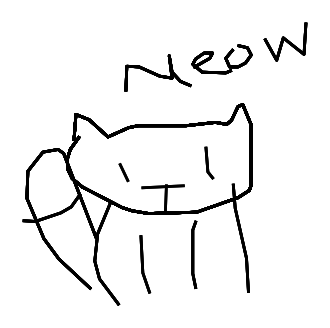

In [2]:
import matplotlib.pyplot as plt

#this is a helper function to visualize the strokes by rendering the drawings
def render_sketch(seq):

    #initialize the pen position
    x, y = 0, 0

    #list to hold all completed strokes
    strokes = []

    #list to hold the x and y coordinates of the current stroke
    stroke_x, stroke_y = [], []

    #iterate through the given sequence of strokes
    for dx, dy, pen in seq:

        #pen position is updated based on the dx and dy values
        x += dx
        y += dy
        #pen position is appended to the current stroke
        stroke_x.append(x)
        stroke_y.append(y)

        #saving the current stroke
        strokes.append((stroke_x, stroke_y))

        #if pen == 1, it indicates a pen-up (end of stroke), so we reset
        if pen == 1:
            stroke_x, stroke_y = [], []


    #plotting the strokes
    plt.figure(figsize=(4, 4))
    for xs, ys in strokes:
        plt.plot(xs, ys, 'k-', linewidth=2) #draw each stroke as a black line with thickness 2
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()


sample = data["train"][0] #picking a sample from the training set
render_sketch(sample) #rendering the sample

# Data Preparation

## creating a dataset class

Below, we will create a custom dataset class to be able to work with our data. We will also visualize the data and its shape

In [3]:
import os
import torch
from torch.utils.data import Dataset

#custom dataset class for loading the SketchRNN data
#It is used to load the sketch sequences and their corresponding labels from the .npz files
class SketchRNNSequenceDataset(Dataset):

    def __init__(self, data_dir, class_names, max_len=300):
        """
        data_dir (str): Directory containing all sketchrnn_*.full.npz files
        class_names (list of str): categories like ['apple', 'cat', ...]
        max_len (int): Max sequence length (for padding or truncation)
        """

        self.samples = [] #list to hold all the samples
        self.max_len = max_len #maximum length of the sequences
        self.class_map = {cls: i for i, cls in enumerate(class_names)} #creates a dictionary that maps class names to numbers -> {"cat": 0, "fish": 1, "pizza": 2, ...}

        #iterating through each class
        for cls in class_names:
            class_index = self.class_map[cls] #get the index of the class
            filename = f"sketchrnn_{cls}.full.npz" #construct the filename
            path = os.path.join(data_dir, filename) #join the directory and filename

            data = np.load(path, allow_pickle=True, encoding="latin1") #load the data
            
            #we will only use data from the training set as it is large enough to constitute a good dataset
            for seq in data["train"][:10000]: #taking only the first 10,000 sequences for each class
                #for each sketch sequence, store a tuple in self.samples containing (seq, label_index)
                self.samples.append((seq, class_index)) 
                # e.g. 
                # (
                #   array([[5, -3, 0], [2, 4, 0], [0, 0, 1], ...]),
                #   0   #index for "cat"
                # )

    #returns the number of samples in the dataset
    def __len__(self):
        return len(self.samples)

    #returns the sample at the given index
    #it returns a tuple containing the sketch sequence, its length, and the class index
    def __getitem__(self, idx):

        #get the sketch sequence and class index
        seq_np, class_idx = self.samples[idx]
        
        #convert to tensor
        seq = torch.tensor(seq_np, dtype=torch.float32)

        #store original length
        length = min(seq.size(0), self.max_len)

        #pad or truncate sequence
        if seq.size(0) < self.max_len:
            pad = torch.zeros(self.max_len - seq.size(0), 3)
            seq = torch.cat([seq, pad], dim=0)
        else:
            seq = seq[:self.max_len]

        #return the sequence, its length, and the class index
        return seq, length, class_idx


Total size: 200000
Train size: 160000
Dev size: 20000
Test size: 20000
torch.Size([300, 3])
48
tree


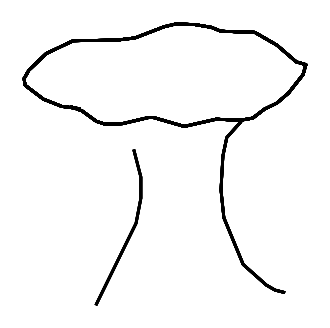

In [9]:
from torch.utils.data import DataLoader, random_split

#all the class names
classes = [
    'cat', 'tree', 'fish', 'clock', 'castle', 'crown', 'lollipop', 'moon',
    'watermelon', 'tornado', 'apple', 'bowtie', 'bicycle', 'diamond',
    'flower', 'butterfly', 'eye', 'lightning', 'cloud', 'pizza'
]

#loading the full dataset
full_dataset = SketchRNNSequenceDataset("data/", classes, max_len=300)

#define split sizes for 80/10/10 split for train/dev/test sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
dev_size = int(0.1 * total_size)
test_size = total_size - train_size - dev_size  # Ensures full coverage

#randomly split the dataset
train_dataset, dev_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, dev_size, test_size]
)

#create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#print sizes to confirm
print(f"Total size: {len(full_dataset)}")
print(f"Train size: {len(train_dataset)}")
print(f"Dev size: {len(dev_dataset)}")
print(f"Test size: {len(test_dataset)}")

#printing the shapes
seq, length, label = train_dataset[0]
print(seq.shape) #[300, 3]
print(length) #original unpadded length
print(classes[label]) #class name

#rendering the sequence as a sketch
valid_seq = seq.numpy()
render_sketch(valid_seq)

sequences shape: torch.Size([64, 300, 3])
lengths shape: torch.Size([64])
labels shape: torch.Size([64])

Label 0: cloud (index 18)


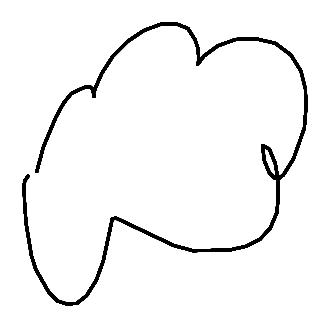


Label 1: bicycle (index 12)


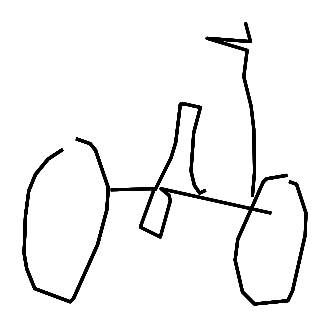


Label 2: fish (index 2)


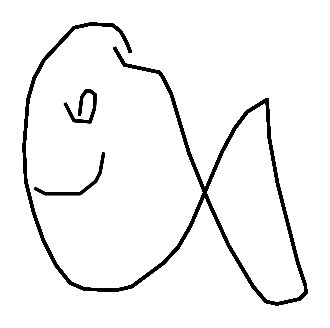


Label 3: crown (index 5)


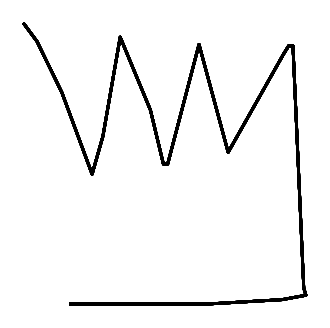


Label 4: cloud (index 18)


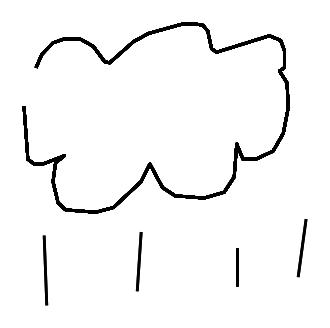


Label 5: castle (index 4)


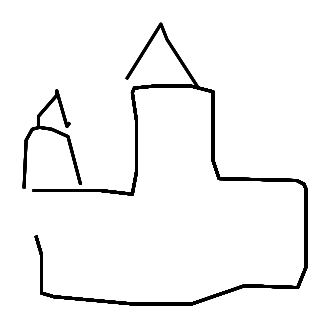

In [10]:
#previewing a batch
sequences, lengths, labels = next(iter(train_loader))
#printing the shapes of the batch
print("sequences shape:", sequences.shape) #expected: (batch_size, max_len, 3)
print("lengths shape:", lengths.shape) #expected: (batch_size,)
print("labels shape:", labels.shape) #expected: (batch_size,)

#rendering the first 6 sketches in the batch
for i in range(6):
    print(f"\nLabel {i}: {classes[labels[i]]} (index {labels[i]})")
    render_sketch(sequences[i].numpy())

# Building the RNN (LSTM) Model

The RNN model used in this implementation is an LSTM-based neural network. It is loosely inspired by the encoder part of the original Sketch-RNN architecture. While the original Sketch-RNN is a full sequence-to-sequence VAE that encodes and then reconstructs stroke-based drawings, my implementation simplifies the architecture for the task of classification.

In particular, we retain only the encoder-like structure of Sketch-RNN, and we keep it unidirectional. The model first projects each input stroke segment (Δx, Δy, pen_state) into a high-dimensional embedding space using a fully connected layer. This is followed by a stack of LSTM layers, which process the sequence step-by-step, capturing temporal patterns in the sketch. The final hidden state of the LSTM serves as a compact summary of the entire drawing.

This summary vector is then passed through a simple classification head (a dropout layer followed by a fully connected layer) that produces the final class probabilities over the 20 sketch categories. 

In [24]:
import torch.nn as nn

class SketchRNN(nn.Module):
    """
    RNN-based model for classifying hand-drawn sketches using LSTM.
    Input: Sequences of pen movements (dx, dy, pen_state)
    Output: Class probabilities over 20 sketch categories
    """

    def __init__(self, num_classes, input_dim=3, hidden_dim=128, num_layers=2, dropout=0.3):
        """
        num_classes (int): Number of output categories/classes
        input_dim (int): Input size at each timestep (dx, dy, pen_state -> 3)
        hidden_dim (int): LSTM hidden size (memory per step)
        num_layers (int): How many LSTM layers to stack
        dropout (float): Dropout between layers (for regularization)
        """
        super().__init__()

        #embed each input timestep (dx, dy, pen) into a higher-dimensional vector space
        #this helps the LSTM learn better representations of strokes
        #we use a linear layer that takes the input of size 3 (dx, dy, pen) and projects it to a higher-dimensional space (hidden_dim=128)
        self.embedding = nn.Linear(input_dim, hidden_dim)  # projects 3 -> 128

        #define a multi-layer LSTM to process the sequence step by step
        #the LSTM will take the embedded input and learn to capture the temporal dependencies in the sketch sequences
        #it will output a hidden state for each timestep, which can be used for classification
        #the LSTM will also have a dropout layer between the layers to prevent overfitting
        self.lstm = nn.LSTM(
            input_size=hidden_dim, #the raw input is [dx, dy, pen] -> 3 values, but note that the embedding step will expand it from 3 to 128
            hidden_size=hidden_dim, #for every stroke, the model outputs a vector of 128 numbers that represent its "understanding" so far
            num_layers=num_layers, #how many LSTM layers to stack
            batch_first=True, #tells pytorch that the input shape is [batch_size, time_steps (strokes per sketch), features (dimension after embedding)]
            dropout=dropout
        )

        #final classification block
        #this will take the final hidden state of the LSTM (a summary of the entire sequence) and project it to the number of classes
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )


    #forward pass: takes a batch of sequences and their lengths and processes the sequences through the embedding layer, LSTM, and classifier
    def forward(self, x, lengths):
        """
        x: Tensor of shape [B, T, 3] -> stroke sequences
        lengths: Tensor of shape [B] -> real lengths before padding
        returns output logits: [B, num_classes], each of the B sketches gets a classification output (each row tells you how confident the model is for each class, per sketch)
        """

        #project each input to hidden_dim by embedding
        x = self.embedding(x)  # [B, T, 3] -> [B, T, H=128]

        #pack the sequence to ignore padding in LSTM
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        #LSTM over the packed input
        #packed_out will be the output of the LSTM for each timestep, but we only need the last hidden state
        #h_n is the final hidden state from each layer
        #since we have 2 LSTM layers, h_n will have shape [num_layers, B, H]
        packed_out, (h_n, c_n) = self.lstm(packed) 
        
        #we only want the final layer's output
        final_hidden = h_n[-1] #[B, H] -> each sketch's last hidden state

        #pass the final hidden state through the classifier
        #this will output the class probabilities for each sketch
        #the classifier takes the final hidden state and projects it to the number of classes
        out = self.classifier(final_hidden)  #[B, num_classes]

        return out


In [31]:
#setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#initializing model and moving to device
model = SketchRNN(num_classes=20).to(device)

#defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


# Training the Model

Epoch 1 | Train Loss: 1.1357 | Train Acc: 66.49% | Val Loss: 0.5811 | Val Acc: 82.53%
Epoch 2 | Train Loss: 0.5413 | Train Acc: 84.10% | Val Loss: 0.4030 | Val Acc: 87.95%
Epoch 3 | Train Loss: 0.4108 | Train Acc: 87.94% | Val Loss: 0.3222 | Val Acc: 90.28%
Epoch 4 | Train Loss: 0.3423 | Train Acc: 89.95% | Val Loss: 0.2895 | Val Acc: 91.44%
Epoch 5 | Train Loss: 0.3022 | Train Acc: 91.15% | Val Loss: 0.2617 | Val Acc: 92.27%
Epoch 6 | Train Loss: 0.2747 | Train Acc: 91.88% | Val Loss: 0.2540 | Val Acc: 92.47%
Epoch 7 | Train Loss: 0.2513 | Train Acc: 92.58% | Val Loss: 0.2290 | Val Acc: 93.36%
Epoch 8 | Train Loss: 0.2334 | Train Acc: 93.12% | Val Loss: 0.2200 | Val Acc: 93.43%
Epoch 9 | Train Loss: 0.2191 | Train Acc: 93.54% | Val Loss: 0.2143 | Val Acc: 93.81%
Epoch 10 | Train Loss: 0.2105 | Train Acc: 93.78% | Val Loss: 0.2024 | Val Acc: 94.16%
Epoch 11 | Train Loss: 0.1991 | Train Acc: 94.16% | Val Loss: 0.1935 | Val Acc: 94.55%
Epoch 12 | Train Loss: 0.1915 | Train Acc: 94.38% | 

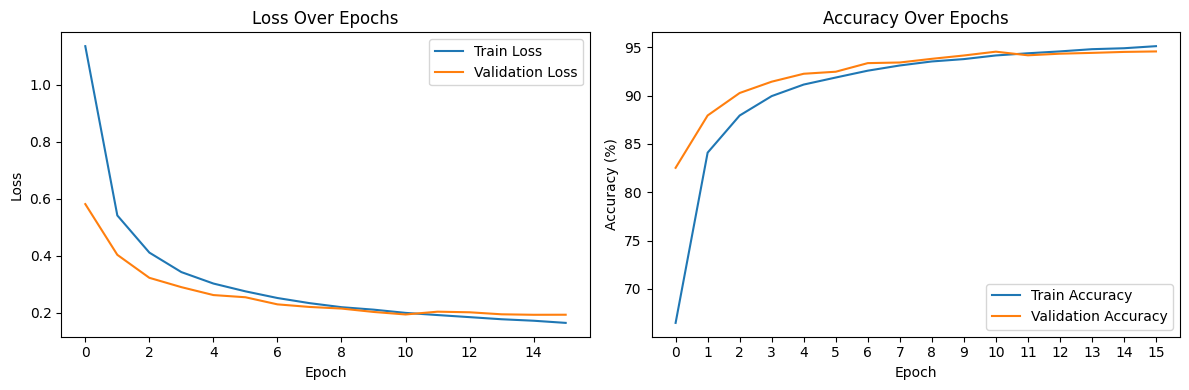

In [32]:
#defining the training function to train the model
#this function will take the model, dataloader, optimizer, loss function, and number of epochs as input and will perform the training loop
#as well as plot the training and validation loss and accuracy
def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=5):
    
    #tracks loss and accuracy for each epoch for plotting
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    #training loop
    for epoch in range(epochs):

        model.train()  #set model to training mode

        #initializing loss and accuracy trackers for training
        total_loss = 0
        correct = 0
        total = 0

        #iterating through the training data
        for sequences, lengths, labels in train_loader:

            #move data to device
            sequences = sequences.to(device) #[B, T, 3]
            lengths = lengths.to(device) #[B]
            labels = labels.to(device) #[B]

            #forward pass
            outputs = model(sequences, lengths) #[B, num_classes]

            #calculate loss
            loss = criterion(outputs, labels)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #update loss and accuracy trackers
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        #calculating average training loss and accuracy
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total * 100

        #--- Validation phase ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for sequences, lengths, labels in dev_loader:
                sequences = sequences.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)

                outputs = model(sequences, lengths)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(dev_loader)
        val_accuracy = val_correct / val_total * 100

        #logging losses and accuracies
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        #printing the results for the epoch
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    #--- Plotting ---
    plt.figure(figsize=(12, 4))

    #loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    #accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.xticks(np.arange(0, epochs, 1))
    plt.legend()

    plt.tight_layout()
    plt.show()


#training the model
train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=16)

# Evaluating the Model


Accuracy: 94.58%


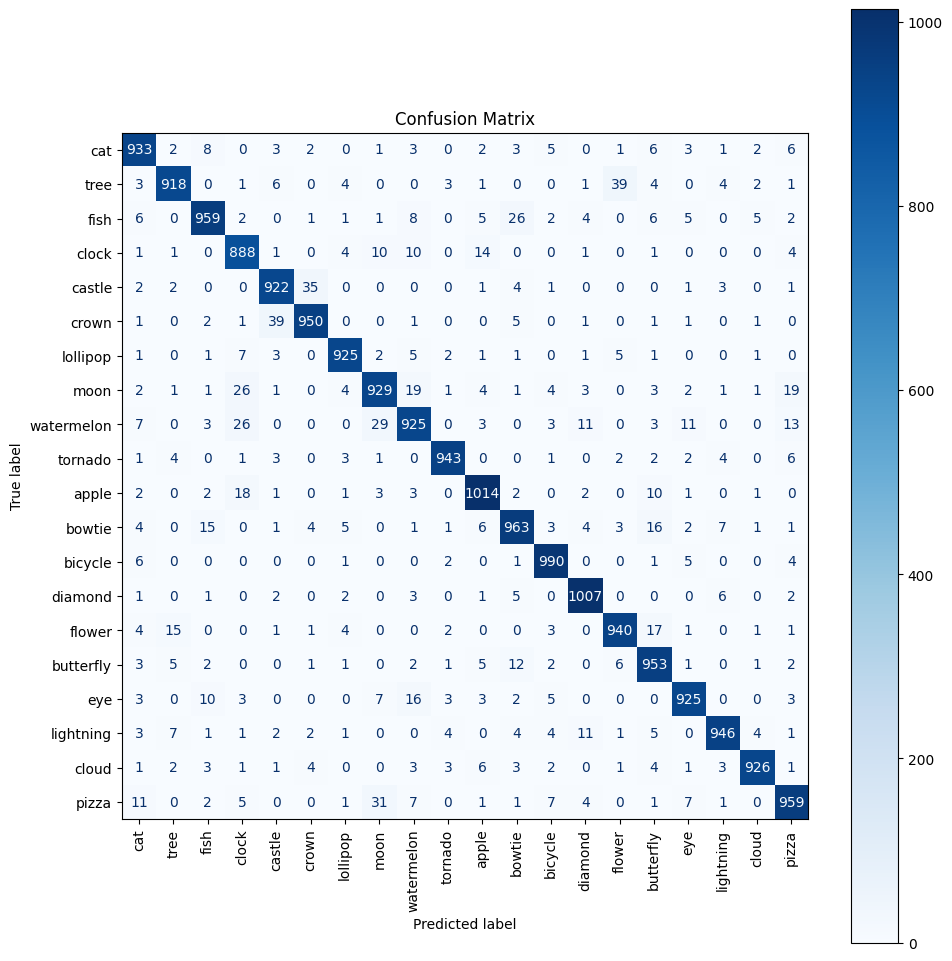

94.575

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#function to evaluate the model on the test set
#this function will take the model, dataloader, and device as input and will perform the evaluation loop
#it will also plot the confusion matrix for better understanding of the model's performance
def evaluate_model(model, dataloader, device):
    
    model.eval() #set model to evaluation mode
    
    all_preds = [] #store all predicted labels
    all_labels = [] #store all true labels

    #initializing accuracy trackers
    correct = 0
    total = 0

    with torch.no_grad(): #no gradient computation needed
        #iterating through the test data
        for sequences, lengths, labels in dataloader:
            #move data to device
            sequences = sequences.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            #forward pass
            outputs = model(sequences, lengths)

            #getting the predicted class indices
            preds = torch.argmax(outputs, dim=1)

            #store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            #count the number of correct predictions
            correct += (preds == labels).sum().item()
            #count the total number of samples in the batch
            total += labels.size(0)

    #calculating accuracy
    accuracy = 100 * correct / total
    #printing the accuracy
    print(f"\nAccuracy: {accuracy:.2f}%")

    #computing the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    #plotting the matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return accuracy

#evaluating the model on the dev set
evaluate_model(model, dev_loader, device)

## Testing how the model works by visualizing its predictions on one sample

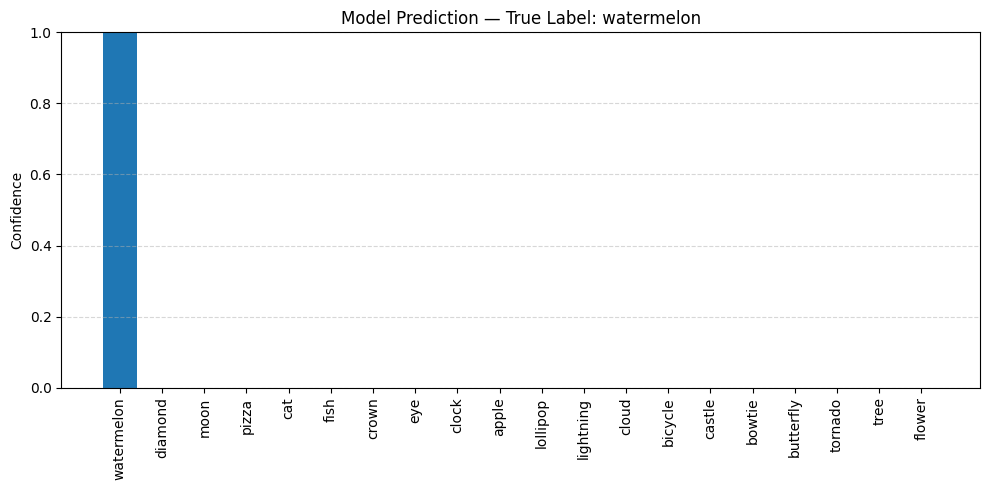

In [34]:
def evaluate_one_sample(model, dataloader, device, class_names):
    """
    Runs the RNN model on one sketch from the test set and shows class probabilities
    """

    model.eval() #set model to evaluation mode

    #get one batch from dataloader
    sequences, lengths, labels = next(iter(dataloader))
    #select the first sample from the batch
    sequence = sequences[0].unsqueeze(0).to(device)
    length = lengths[0].unsqueeze(0).to(device)
    label = labels[0].item()

    with torch.no_grad(): #no gradient computation needed
        #forward pass
        output = model(sequence, length)
        #output is the raw scores for each class, we need to apply softmax to get probabilities
        probs = torch.softmax(output, dim=1)

    #probs is a tensor of shape [1, num_classes], we need to squeeze it to get [num_classes]
    probs = probs.squeeze().cpu().numpy()

    #map class names to probabilities
    class_probs = list(zip(class_names, probs))

    #sort by confidence
    class_probs.sort(key=lambda x: x[1], reverse=True)

    #plot all class probabilities as a bar chart
    labels_list, values = zip(*class_probs) #splits class names and probabilities into two separate lists
    plt.figure(figsize=(10, 5))
    plt.bar(labels_list, values)
    plt.xticks(rotation=90)
    plt.title(f"Model Prediction — True Label: {class_names[label]}")
    plt.ylabel("Confidence")
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

evaluate_one_sample(model, test_loader, device, classes)


Accuracy: 94.51%


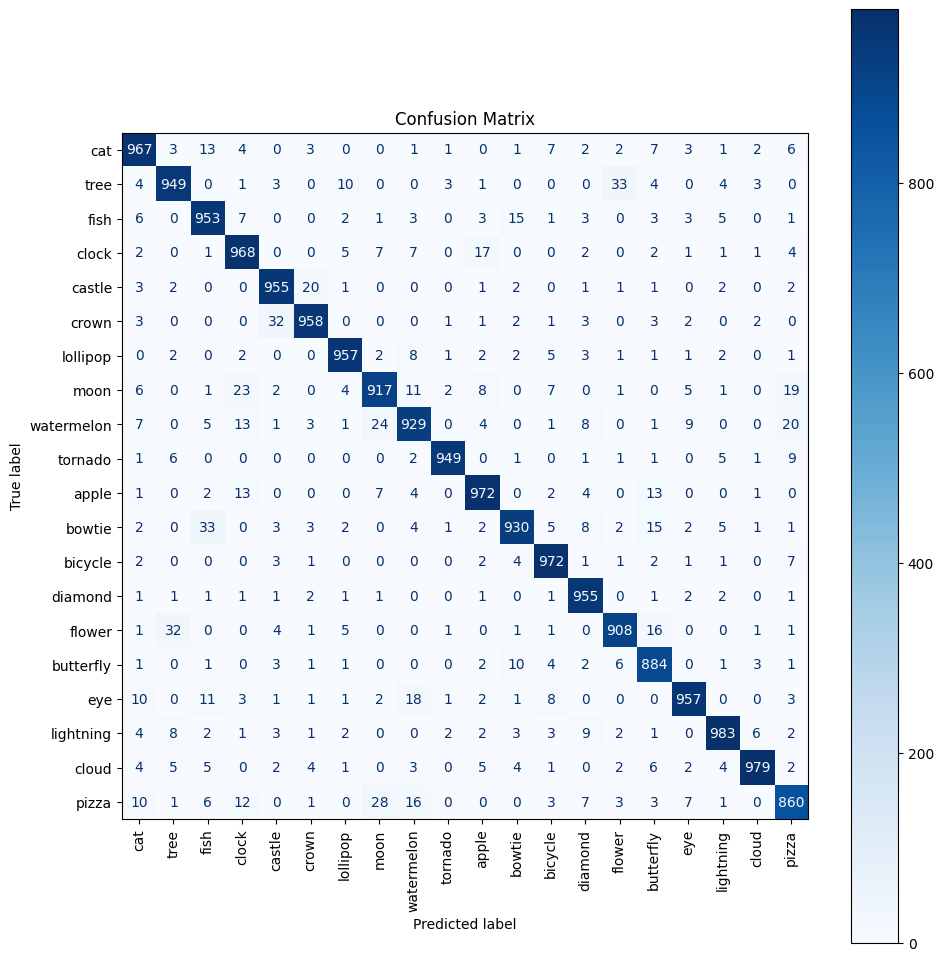

94.51

In [35]:
#evaluating the model on the test set
evaluate_model(model, test_loader, device)

# Saving the Model

In [37]:
#save model weights to a file
torch.save(model.state_dict(), "model2.pth")